In [1]:
import pandas as pd
import numpy as np
import json
import os
import string
import re
import random

import nltk
from nltk import word_tokenize
from nltk.corpus import (wordnet, stopwords)
from nltk.stem.snowball import SnowballStemmer

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt

from sklearn.linear_model import (LogisticRegression, LogisticRegressionCV)
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.feature_selection import RFE
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import (confusion_matrix, 
                             recall_score, 
                             f1_score, 
                             accuracy_score, 
                             precision_score,
                             roc_curve, auc, roc_auc_score)

import warnings
warnings.filterwarnings('ignore')

from datetime import *
from bisect import bisect

In [2]:
email = pd.read_csv('features_id_text.csv')
#email.index = email['Unnamed: 0']
email = email.drop('Unnamed: 0', axis = 1)
list(email)

['likes',
 'n_tweets',
 'replies',
 'retweets',
 'time_business',
 'time_early',
 'time_evening',
 'time_late',
 'weekday_mean',
 'wkday_0',
 'wkday_1',
 'wkday_2',
 'wkday_3',
 'wkday_4',
 'wkday_5',
 'wkday_6',
 'LDA_0',
 'LDA_1',
 'LDA_2',
 'LDA_3',
 'LDA_4',
 'LDA_5',
 'LDA_6',
 'LDA_7',
 'LDA_8',
 'LDA_9',
 'LDA_10',
 'LDA_11',
 'LDA_12',
 'LDA_13',
 'LDA_14',
 'LDA_15',
 'LDA_16',
 'LDA_17',
 'LDA_18',
 'LDA_19',
 'Negative Sentiment',
 'Positive Sentiment',
 'Neutral Sentiment',
 'variable',
 'ratio',
 'binary_label']

In [3]:
full_data = email
#drop the user in turkish
full_data = full_data.drop(full_data[full_data.index == 2697].index)
#drop not common tweeters
#full_data = full_data.drop(full_data[full_data.n_tweets == 1].index)
#full_data = full_data.drop(full_data[full_data.n_tweets > 800].index)

In [4]:
def create_folds(full_data, n_folds): 
    X = full_data.drop(['variable', 'binary_label'], axis = 1).as_matrix()
    y = full_data.as_matrix(['binary_label'])
    ints = [list(test_index) 
            for train_index, test_index in StratifiedKFold(n_folds, shuffle = True).split(X, y)]
    return [full_data.iloc[ints[i],:] for i in range(n_folds)]

fold1, fold2, fold3, fold4, fold5 = create_folds(full_data,5)

In [5]:
def binary_metrics (test, label, pred):
    acc = accuracy_score(test[label], test[pred])
    f1 = f1_score(test[label], test[pred])
    prec = precision_score(test[label], test[pred])
    rec = recall_score(test[label], test[pred])
    roc_auc = roc_auc_score(test[label], test[pred])
    
    return roc_auc, acc, prec, rec, f1

def plot_metrics (test, label, pred):
    tn, fp, fn, tp = confusion_matrix(test[label], test[pred]).ravel()
    roc_auc, acc, prec, rec, f1 = binary_metrics(test, label, pred)
    roc = roc_curve(test[label], test[pred])
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(test[label].nunique()):
        fpr[i], tpr[i], _ = roc_curve(test[label], test[pred])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(test[label].ravel(), test[pred].ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    plt.figure(figsize=(8,5))
    lw = 2
    plt.plot(fpr[1], tpr[1], color='gold',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[1])
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Example')
    plt.legend(loc="lower right")
    plt.show()
    
    show_confusion_matrix(test, label, pred)
    
    return roc_auc[0], acc, prec, rec, f1

def show_confusion_matrix(test, label, pred):
    
    C = confusion_matrix(test[label], test[pred])
    tn, fp, fn, tp = C.ravel()
    
    NP = fn+tp # Num positive examples
    NN = tn+fp # Num negative examples
    N  = NP+NN

    fig = plt.figure(figsize=(8,8))
    ax  = fig.add_subplot(111)
    ax.imshow(C, cmap=plt.cm.gray)

    # Draw the grid boxes
    ax.set_xlim(-0.5,2.5)
    ax.set_ylim(2.5,-0.5)
    ax.plot([-0.5,2.5],[0.5,0.5], '-k', lw=2)
    ax.plot([-0.5,2.5],[1.5,1.5], '-k', lw=2)
    ax.plot([0.5,0.5],[-0.5,2.5], '-k', lw=2)
    ax.plot([1.5,1.5],[-0.5,2.5], '-k', lw=2)


    # Set xlabels
    ax.set_xlabel('Predicted Label', fontsize=16)
    ax.set_xticks([0,1,2])
    ax.set_xticklabels(['Show', 'No Show'])
    ax.xaxis.set_label_position('top')
    ax.xaxis.tick_top()
    # These coordinate might require some tinkering. Ditto for y, below.
    ax.xaxis.set_label_coords(0.34,1.06)

    # Set ylabels
    ax.set_ylabel('True Label', fontsize=16, rotation=90)
    ax.set_yticklabels(['Bad', 'Good'])
    ax.set_yticks([0,1,2])
    ax.yaxis.set_label_coords(-0.09,0.65)


    # Fill in initial metrics: tp, tn, etc...
    ax.text(0,0,'True Negatives: %d\n(Total Negatives: %d)'%(tn,NN),
            va='center', ha='center', bbox=dict(fc='w',boxstyle='round,pad=1'))
    ax.text(0,1,'False Negatives: %d'%fn,
            va='center', ha='center', bbox=dict(fc='w',boxstyle='round,pad=1'))
    ax.text(1,0,'False Positives: %d'%fp,
           va='center', ha='center', bbox=dict(fc='w',boxstyle='round,pad=1'))
    ax.text(1,1,'True Positives: %d\n(Total Positives: %d)'%(tp,NP),
            va='center', ha='center', bbox=dict(fc='w',boxstyle='round,pad=1'))
    # Fill in secondary metrics: accuracy, true pos rate, etc...
    ax.text(2,0,'True Negative Rate' + '\n' +'(Specificity):%.2f'%(tn / (fp+tn+0.)),
            va='center', ha='center', bbox=dict(fc='w',boxstyle='round,pad=1'))
    ax.text(2,1,'True Positive Rate' + '\n' + '(Sensitivity):%.2f'%(tp / (tp+fn+0.)),
            va='center', ha='center', bbox=dict(fc='w',boxstyle='round,pad=1'))
    ax.text(2,2,'F-1 Score: %.2f'%(round(2*tp/((2*tp) + fp + fn),3)),
            va='center', ha='center', bbox=dict(fc='w',boxstyle='round,pad=1'))
    ax.text(0,2,'Negative Predictive ' + '\n' + 'Value: %.2f'%(1-fn/(fn+tn+0.)),
           va='center', ha='center', bbox=dict(fc='w',boxstyle='round,pad=1'))
    ax.text(1,2,'Positive Predictive ' + '\n' + 'Value: %.2f'%(tp/(tp+fp+0.)),
            va='center', ha='center', bbox=dict(fc='w',boxstyle='round,pad=1'))
    plt.tight_layout()
    plt.show()
    
    return None

def run_model_lr(full, test, label, pred, plot = False, CV = False):
    train = pd.concat([full, test]).drop_duplicates(keep=False)
    trainArr = train.drop(['variable', 'binary_label'], axis = 1).as_matrix()
    trainRes = train.as_matrix(['binary_label'])
    testArr = test.drop(['variable', 'binary_label'], axis = 1).as_matrix()
    
    if CV:
        lr = LogisticRegressionCV(scoring = 'roc_auc')
        lr.fit(trainArr, trainRes)
        lr.fit(trainArr, trainRes)
        predictions = lr.predict(testArr)
        
    else:
    #gridsearch
        param_test1 = {'C':[0.0001,0.001,0.01,0.1,1,10,100,1000],
                       'solver':['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
                      }
        gridsearch = GridSearchCV(estimator = LogisticRegression(class_weight = 'balanced'),
                                  param_grid = param_test1, scoring = 'roc_auc')

        gridsearch.fit(trainArr,trainRes)

        lr = LogisticRegression(C=list(gridsearch.best_params_.values())[0],
                                    solver=list(gridsearch.best_params_.values())[1])

        lr.fit(trainArr, trainRes) 
        predictions = lr.predict(testArr)
        
    data = pd.DataFrame(list(test[label]),columns=[label], index = test.index)
    data[pred] = pd.Series(list(predictions), index=data.index)                
    
    if plot:
        roc_auc, acc, prec, rec, f1 = plot_metrics(data, label, pred)
    else:
        roc_auc, acc, prec, rec, f1 = binary_metrics(data, label, pred)
    
    return data, [roc_auc, acc, prec, rec, f1]

In [6]:
def run_model_rfc (full, test, label, pred, plot = False):
    train = pd.concat([full, test]).drop_duplicates(keep=False)
    trainArr = train.drop(['variable', 'binary_label'], axis = 1).as_matrix()
    trainRes = train.as_matrix(['binary_label'])
    testArr = test.drop(['variable', 'binary_label'], axis = 1).as_matrix()
    
    
    param_test1 = {'n_estimators':np.arange(20,111,10).tolist(), 
                   'max_features':np.arange(0.1,1,0.1).tolist()
                   , 'class_weight':['balanced', None]
                   ,'criterion':['gini', 'entropy']
                  }
    gridsearch = GridSearchCV(estimator = RandomForestClassifier(random_state=10),
                              param_grid = param_test1, scoring = 'roc_auc', n_jobs=4,iid=False, cv=5)

    gridsearch.fit(trainArr,trainRes)
    
    predictions = gridsearch.predict(testArr)
    
    data = pd.DataFrame(list(test[label]),columns=[label], index = test.index)
    data[pred] = pd.Series(list(predictions), index=data.index) 
    
    if plot:
        roc_auc, acc, prec, rec, f1 = plot_metrics(data, label, pred)
    else:
        roc_auc, acc, prec, rec, f1 = binary_metrics(data, label, pred)    
    
    return data, [roc_auc, acc, prec, rec, f1]

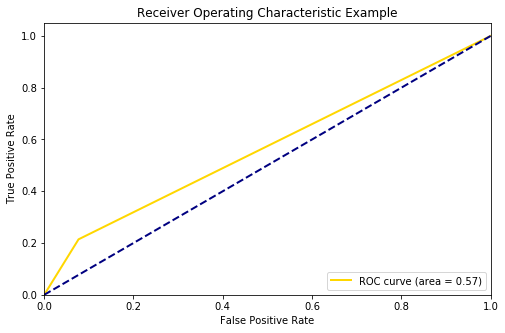

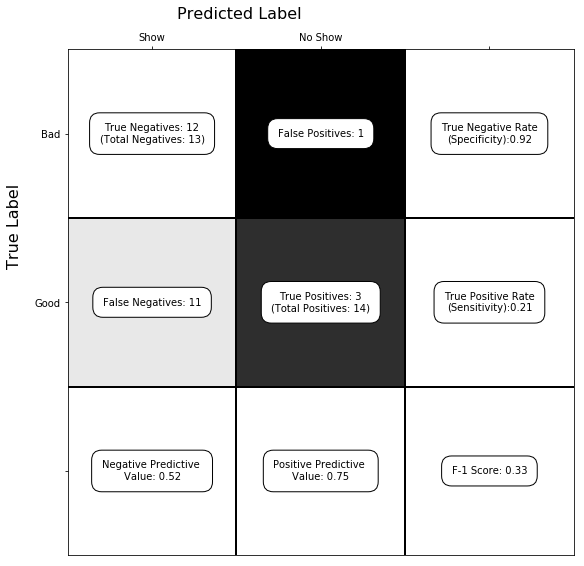

,ROC AUC Score,Accuracy,Recall,Precision,F-1 Score
Fold 1,0.554945,0.555556,0.571429,0.571429,0.571429
Fold 2,0.552198,0.555556,0.562500,0.642857,0.600000
Fold 3,0.596154,0.592593,0.636364,0.500000,0.560000
Fold 4,0.541209,0.555556,0.541667,0.928571,0.684211
Fold 5,0.568681,0.555556,0.750000,0.214286,0.333333
Mean,0.562637,0.562963,0.612392,0.571429,0.549794


In [7]:
label, pred = 'binary_label', 'predictions'

t1, b1 = run_model_lr(full_data, fold1, label, pred)
t2, b2 = run_model_lr(full_data, fold2, label, pred)
t3, b3 = run_model_lr(full_data, fold3, label, pred)
t4, b4 = run_model_lr(full_data, fold4, label, pred)
t5, b5 = run_model_lr(full_data, fold5, label, pred, plot = True)

binary = pd.DataFrame([b1, b2, b3, b4, b5])
binary.columns = ['ROC AUC Score','Accuracy', 'Recall', 'Precision', 'F-1 Score']
binary.index = ['Fold 1', 'Fold 2', 'Fold 3', 'Fold 4', 'Fold 5']
binary.loc['Mean'] = binary.mean()
binary

### inter fold variation
### new models to try

In [8]:
t1, b1 = run_model_rfc(full_data, fold1, label, pred)
t2, b2 = run_model_rfc(full_data, fold2, label, pred)
t3, b3 = run_model_rfc(full_data, fold3, label, pred)
t4, b4 = run_model_rfc(full_data, fold4, label, pred)
t5, b5 = run_model_rfc(full_data, fold5, label, pred)

binary = pd.DataFrame([b1, b2, b3, b4, b5])
binary.columns = ['ROC AUC Score','Accuracy', 'Recall', 'Precision', 'F-1 Score']
binary.index = ['Fold 1', 'Fold 2', 'Fold 3', 'Fold 4', 'Fold 5']
binary.loc['Mean'] = binary.mean()
binary

,ROC AUC Score,Accuracy,Recall,Precision,F-1 Score
Fold 1,0.629121,0.629630,0.642857,0.642857,0.642857
Fold 2,0.554945,0.555556,0.571429,0.571429,0.571429
Fold 3,0.516484,0.518519,0.533333,0.571429,0.551724
Fold 4,0.664835,0.666667,0.666667,0.714286,0.689655
Fold 5,0.637363,0.629630,0.750000,0.428571,0.545455
Mean,0.600549,0.600000,0.632857,0.585714,0.600224


In [9]:
def run_model_lr_rfe(full, test, label, pred, plot = False, CV = False):
    train = pd.concat([full, test]).drop_duplicates(keep=False)
    trainArr = train.drop(['variable', 'binary_label'], axis = 1).as_matrix()
    trainRes = train.as_matrix(['binary_label'])
    testArr = test.drop(['variable', 'binary_label'], axis = 1).as_matrix()
    
    if CV:
        estimator = LogisticRegressionCV(scoring = 'roc_auc')
        
    else:
    #gridsearch
        param_test1 = {'C':[0.0001,0.001,0.01,0.1,1,10,100,1000],
                       'solver':['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
                      }
        gridsearch = GridSearchCV(estimator = LogisticRegression(class_weight = 'balanced'),
                                  param_grid = param_test1, scoring = 'roc_auc')

        gridsearch.fit(trainArr,trainRes)

        estimator = LogisticRegression(C=list(gridsearch.best_params_.values())[0],
                                    solver=list(gridsearch.best_params_.values())[1])
    
    selector = RFE(estimator, step=1)
    selector = selector.fit(trainArr, trainRes)
    predictions = selector.predict(testArr)
        
    data = pd.DataFrame(list(test[label]),columns=[label], index = test.index)
    data[pred] = pd.Series(list(predictions), index=data.index)                
    
    if plot:
        roc_auc, acc, prec, rec, f1 = plot_metrics(data, label, pred)
    else:
        roc_auc, acc, prec, rec, f1 = binary_metrics(data, label, pred)
    
    return data, [roc_auc, acc, prec, rec, f1]

In [10]:
t1, b1 = run_model_lr_rfe(full_data, fold1, label, pred, CV = True)
t2, b2 = run_model_lr_rfe(full_data, fold2, label, pred, CV = True)
t3, b3 = run_model_lr_rfe(full_data, fold3, label, pred, CV = True)
t4, b4 = run_model_lr_rfe(full_data, fold4, label, pred, CV = True)
t5, b5 = run_model_lr_rfe(full_data, fold5, label, pred, CV = True)

binary = pd.DataFrame([b1, b2, b3, b4, b5])
binary.columns = ['ROC AUC Score','Accuracy', 'Recall', 'Precision', 'F-1 Score']
binary.index = ['Fold 1', 'Fold 2', 'Fold 3', 'Fold 4', 'Fold 5']
binary.loc['Mean'] = binary.mean()
binary

,ROC AUC Score,Accuracy,Recall,Precision,F-1 Score
Fold 1,0.445055,0.444444,0.461538,0.428571,0.444444
Fold 2,0.590659,0.592593,0.600000,0.642857,0.620690
Fold 3,0.428571,0.444444,0.480000,0.857143,0.615385
Fold 4,0.450549,0.444444,0.444444,0.285714,0.347826
Fold 5,0.664835,0.666667,0.666667,0.714286,0.689655
Mean,0.515934,0.518519,0.530530,0.585714,0.543600
